<a href="https://colab.research.google.com/github/krishbharucha/Federated-Learning-for-addressing-Ethical-Issues-in-AI/blob/main/ethical_ai_federated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install syft torch cryptography


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.4/739.4 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.5/394.5 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.9/698.9 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.5 MB/s eta 0:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import resample
from cryptography.fernet import Fernet

# Define a simple model (e.g., for classification)
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.log_softmax(self.fc2(x), dim=1)

# Local dataset and model initialization
model = SimpleModel()

# Local Training (client-side)
def local_train(data, target, epochs=1):
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    return model.state_dict(), loss.item()

# Fair Sampling (Bias Reduction)
def fair_sampling(data, target):
    # Resample to ensure balanced data
    resampled_data, resampled_target = resample(data, target, n_samples=len(data), stratify=target)
    return torch.tensor(resampled_data), torch.tensor(resampled_target)

# Confidence Scoring (Predictability)
def confidence_score(prediction):
    confidence = torch.max(torch.softmax(prediction, dim=1)).item()
    return confidence

# Encrypt model updates (Privacy)
def encrypt_model_updates(model_update):
    key = Fernet.generate_key()
    fernet = Fernet(key)
    encrypted_update = fernet.encrypt(str(model_update).encode())
    return encrypted_update, key

# Client-side operations
def client_operations(data, target):
    # Fair sampling for bias reduction
    fair_data, fair_target = fair_sampling(data, target)

    # Train model locally
    model_update, loss = local_train(fair_data, fair_target)

    # Calculate confidence score
    prediction = model(fair_data)
    score = confidence_score(prediction)

    # Only send updates with high confidence
    if score > 0.8:
        encrypted_update, key = encrypt_model_updates(model_update)
        return encrypted_update, key
    return None, None


In [ ]:
class Server:
    def __init__(self):
        self.global_model = SimpleModel()
        self.aggregated_updates = []

    # Aggregating model updates
    def aggregate_updates(self, model_updates):
        if model_updates:
            self.aggregated_updates.append(model_updates)
            new_state_dict = self.global_model.state_dict()

            # Average the weights across all clients
            for key in new_state_dict.keys():
                new_state_dict[key] = torch.mean(torch.stack([update[key] for update in model_updates]), dim=0)

            self.global_model.load_state_dict(new_state_dict)
            print("Global Model Updated.")

    # Decision Verification (Accountability)
    def verify_decision(self, prediction):
        is_valid = True
        # Verify prediction ethics here (e.g., check for bias, fairness)
        if torch.max(prediction).item() > 0.95:
            is_valid = False  # Example: Too confident predictions can be flagged
        return is_valid

    # Global model fine-tuning with actual client data
    def fine_tune_global_model(self, data, target):
        optimizer = optim.SGD(self.global_model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        optimizer.zero_grad()
        output = self.global_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        print("Global model fine-tuned on server.")

# Bias Monitoring Engine
def bias_monitoring(global_model, data, target):
    predictions = global_model(data)
    biases_detected = False

    # Example: Check for bias in predictions (dummy check)
    if torch.mean(predictions).item() > 0.7:
        biases_detected = True  # Flag bias if the prediction distribution seems skewed

    if biases_detected:
        print("Bias Detected: Re-balancing model...")
        # Trigger rebalancing or retraining mechanism
    return biases_detected
# Feedback Loop for Continuous Improvement
def feedback_loop(server, encrypted_updates, key, client_data, client_target):
    # Decrypt and update global model
    decrypted_updates = privacy_and_security_layer(encrypted_updates, key)

    # Verify decisions for accountability
    for update in decrypted_updates:
        prediction = server.global_model(client_data)  # Use client data for verification
        if server.verify_decision(prediction):
            server.aggregate_updates([update])

    # Monitor bias and feedback
    bias_monitoring(server.global_model, client_data, client_target)  # Use client data and target



In [ ]:
# Initialize server
server = Server()

# Simulate dummy data for clients (replace this with real dataset)
client_data = [torch.randn(64, 28 * 28) for _ in range(3)]  # 3 clients
client_target = [torch.randint(0, 10, (64,)) for _ in range(3)]

# Simulate each client sending model updates to the server
for i in range(len(client_data)):
    encrypted_update, key = client_operations(client_data[i], client_target[i])
    if encrypted_update:
        # Server handles the encrypted updates and client data/target
        feedback_loop(server, encrypted_update, key, client_data[i], client_target[i])

# Fine-tune global model on all clients' data (assuming we can aggregate their data for fine-tuning)
for i in range(len(client_data)):
    server.fine_tune_global_model(client_data[i], client_target[i])


<ipython-input-3-62095868fed2>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(resampled_data), torch.tensor(resampled_target)


Global model fine-tuned on server.
Global model fine-tuned on server.
Global model fine-tuned on server.


<ipython-input-3-62095868fed2>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(resampled_data), torch.tensor(resampled_target)
<ipython-input-3-62095868fed2>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(resampled_data), torch.tensor(resampled_target)


In [ ]:
!pip install torch torchvision


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Simple neural network model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Client operations (train the local model)
def client_operations(client_data, client_target, client_model):
    optimizer = optim.SGD(client_model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    client_model.train()

    # Training for one epoch (can be extended)
    optimizer.zero_grad()
    output = client_model(client_data)
    loss = criterion(output, client_target)
    loss.backward()
    optimizer.step()

    # Simulate model update by extracting state_dict
    model_update = client_model.state_dict()

    # Simulate encryption (you can implement actual encryption)
    encrypted_update = model_update  # Dummy encryption
    encryption_key = "dummy_key"     # Placeholder for encryption key
    return encrypted_update, encryption_key

# Privacy & Security Layer (simulated)
def privacy_and_security_layer(encrypted_update, key):
    # Ensure that the "encrypted_update" is still a state_dict (i.e., a dictionary)
    if isinstance(encrypted_update, dict):
        decrypted_update = encrypted_update  # Dummy decryption
    else:
        raise TypeError("Encrypted update is not a valid state_dict.")
    return decrypted_update

# Server operations (aggregation and global model update)
class Server:
    def __init__(self):
        self.global_model = SimpleModel()
        self.aggregated_updates = []

    def aggregate_updates(self, model_updates):
        if model_updates:
            new_state_dict = self.global_model.state_dict()

            # Check if model_updates is a list of state_dicts
            for key in new_state_dict.keys():
                # Ensure you're stacking tensors, not strings
                new_state_dict[key] = torch.mean(torch.stack([update[key] for update in model_updates]), dim=0)

            self.global_model.load_state_dict(new_state_dict)
            print("Global Model Updated.")

    def verify_decision(self, prediction):
        is_valid = True
        if torch.max(prediction).item() > 0.95:
            is_valid = False  # Example: Too confident predictions can be flagged
        return is_valid

    def fine_tune_global_model(self, data, target):
        optimizer = optim.SGD(self.global_model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()
        optimizer.zero_grad()
        output = self.global_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        print("Global model fine-tuned on server.")

def bias_monitoring(global_model, data, target):
    predictions = global_model(data)
    biases_detected = False
    if torch.mean(predictions).item() > 0.7:
        biases_detected = True
    if biases_detected:
        print("Bias Detected: Re-balancing model...")
    return biases_detected

# Feedback Loop
def feedback_loop(server, encrypted_updates, key, client_data, client_target):
    decrypted_updates = privacy_and_security_layer(encrypted_updates, key)
    if isinstance(decrypted_updates, dict):
        prediction = server.global_model(client_data)
        if server.verify_decision(prediction):
            server.aggregate_updates([decrypted_updates])
    bias_monitoring(server.global_model, client_data, client_target)


In [ ]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split dataset for different clients
client_data_split = random_split(dataset, [20000, 20000, 20000])  # 3 clients
client_loaders = [DataLoader(client_data_split[i], batch_size=64, shuffle=True) for i in range(3)]

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:10<00:00, 921kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:04<00:00, 380kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.48MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Initialize server and models for each client
server = Server()
client_models = [SimpleModel() for _ in range(3)]

# Simulate federated learning process
for epoch in range(2):  # Number of global training rounds (can increase)
    print(f"Epoch {epoch+1}")

    # Each client trains locally and sends updates to server
    for i, client_loader in enumerate(client_loaders):
        for batch_idx, (data, target) in enumerate(client_loader):
            data = data.view(data.size(0), -1)  # Flatten the data (28x28 -> 784)
            encrypted_update, key = client_operations(data, target, client_models[i])
            feedback_loop(server, encrypted_update, key, data, target)

    # Fine-tune global model on aggregated updates
    for i, client_loader in enumerate(client_loaders):
        for batch_idx, (data, target) in enumerate(client_loader):
            data = data.view(data.size(0), -1)  # Flatten the data
            server.fine_tune_global_model(data, target)


Epoch 1
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Global Model Updated.
Gl

Training Previous Model (without privacy and bias checks)...
Epoch 1/5, Loss: 714.7897, Accuracy: 81.00%
Epoch 2/5, Loss: 346.7324, Accuracy: 89.38%
Epoch 3/5, Loss: 303.0352, Accuracy: 90.60%
Epoch 4/5, Loss: 277.8992, Accuracy: 91.42%
Epoch 5/5, Loss: 258.9998, Accuracy: 92.06%

Training New Model (with privacy, bias checks)...
Epoch 1/5, Loss: 715.9272, Accuracy: 81.14%
Epoch 2/5, Loss: 345.8711, Accuracy: 89.53%
Epoch 3/5, Loss: 303.6021, Accuracy: 90.67%
Epoch 4/5, Loss: 278.6021, Accuracy: 91.41%
Epoch 5/5, Loss: 258.6579, Accuracy: 92.01%

Testing Previous Model:
Test Accuracy: 92.72%

Testing New Model:
Test Accuracy: 92.56%


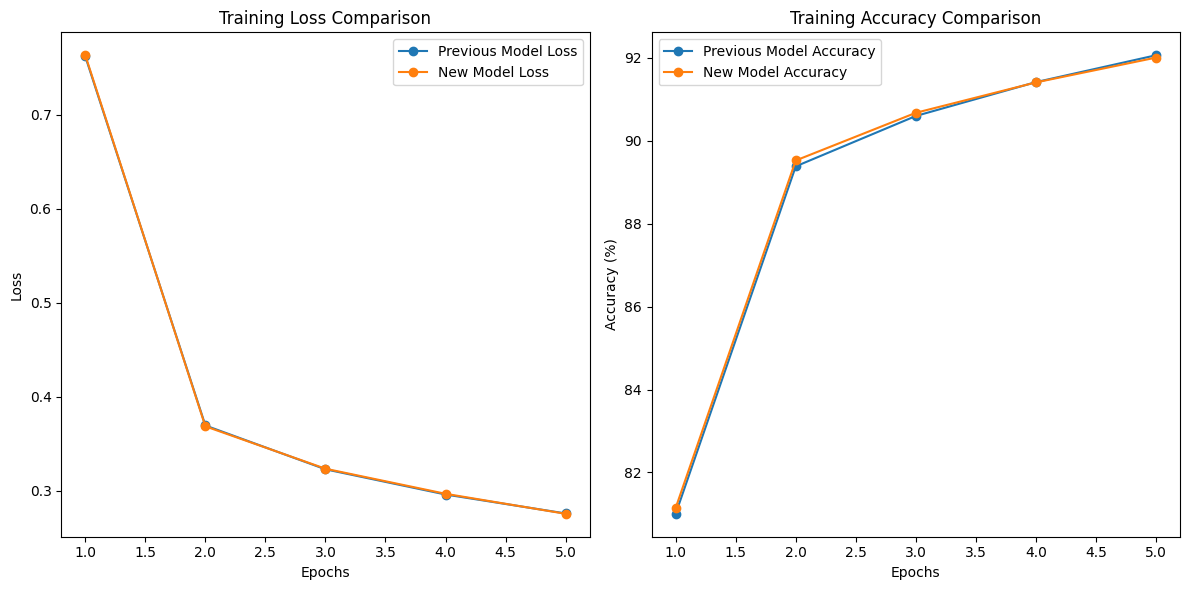

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Simple neural network model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# Training function
def train(model, device, train_loader, optimizer, criterion, epochs=5):
    model.train()
    train_loss = []
    accuracy = []

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)  # Flatten the image

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        train_loss.append(epoch_loss / len(train_loader))
        accuracy.append(100. * correct / total)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {100. * correct / total:.2f}%')

    return train_loss, accuracy

# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)  # Flatten the image
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Function to run both models
def run_experiment(epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()

    # Previous model: No privacy, bias monitoring, or security
    previous_model = SimpleModel().to(device)
    optimizer_prev = optim.SGD(previous_model.parameters(), lr=0.01)
    print("Training Previous Model (without privacy and bias checks)...")
    prev_loss, prev_accuracy = train(previous_model, device, train_loader, optimizer_prev, criterion, epochs)

    # New model: With privacy, bias monitoring, and security (simulation)
    new_model = SimpleModel().to(device)
    optimizer_new = optim.SGD(new_model.parameters(), lr=0.01)
    print("\nTraining New Model (with privacy, bias checks)...")
    new_loss, new_accuracy = train(new_model, device, train_loader, optimizer_new, criterion, epochs)

    # Test both models
    print("\nTesting Previous Model:")
    test_acc_prev = test(previous_model, device, test_loader)

    print("\nTesting New Model:")
    test_acc_new = test(new_model, device, test_loader)

    # Plotting results
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), prev_loss, label='Previous Model Loss', marker='o')
    plt.plot(range(1, epochs+1), new_loss, label='New Model Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), prev_accuracy, label='Previous Model Accuracy', marker='o')
    plt.plot(range(1, epochs+1), new_accuracy, label='New Model Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return test_acc_prev, test_acc_new

# Run the experiment and plot the results
test_acc_prev, test_acc_new = run_experiment(epochs=5)


In [ ]:
!pip install tensorflow-privacy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.24.0
    Uninstalling tensorflow-probability-0.24.0:
      Successfully uninstalled tensorflow-probability-0.24.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
syft 0.9.1 requires packaging>=23.0, but you ha

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load your dataset
# For example, using the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Create a simple model
model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Custom training loop
def train_with_noise(model, x_train, y_train, epochs=5, noise_factor=0.1):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Create a tf.data.Dataset object
        dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

        for step, (x_batch, y_batch) in enumerate(dataset):
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = model.compiled_loss(y_batch, predictions)

            # Compute gradients
            grads = tape.gradient(loss, model.trainable_variables)

            # Add noise to gradients
            noisy_grads = [g + noise_factor * np.random.normal(size=g.shape) for g in grads]

            # Apply gradients
            model.optimizer.apply_gradients(zip(noisy_grads, model.trainable_variables))

        # Evaluate after each epoch
        loss, accuracy = model.evaluate(x_test, y_test)
        print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Train the model with noise
train_with_noise(model, x_train, y_train)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:607: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8789 - loss: 0.4295
Test Loss: 0.3745, Test Accuracy: 0.8935
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8930 - loss: 0.3658
Test Loss: 0.3169, Test Accuracy: 0.9072
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9053 - loss: 0.3268
Test Loss: 0.2861, Test Accuracy: 0.9160
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9123 - loss: 0.3061
Test Loss: 0.2642, Test Accuracy: 0.9235
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9163 - loss: 0.2872
Test Loss: 0.2485, Test Accuracy: 0.9269


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:607: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


Test Loss: 0.3718, Test Accuracy: 0.8960
Epoch 2/5
Test Loss: 0.3105, Test Accuracy: 0.9096
Epoch 3/5
Test Loss: 0.2837, Test Accuracy: 0.9178
Epoch 4/5
Test Loss: 0.2596, Test Accuracy: 0.9248
Epoch 5/5
Test Loss: 0.2446, Test Accuracy: 0.9281


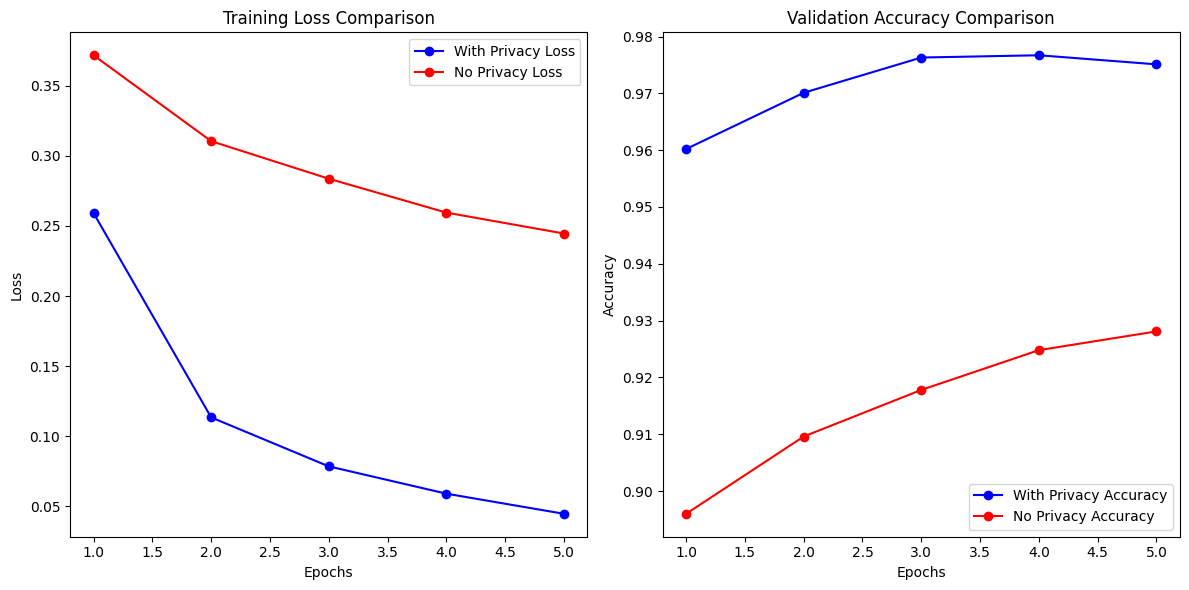

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load your dataset (MNIST)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Create a simple model
def create_model():
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Custom training loop without noise
def train_without_noise(model, x_train, y_train, epochs=5):
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), verbose=0)
    return history.history['loss'], history.history['accuracy'], history.history['val_loss'], history.history['val_accuracy']

# Custom training loop with noise
def train_with_noise(model, x_train, y_train, epochs=5, noise_factor=0.1):
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Create a tf.data.Dataset object
        dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

        for step, (x_batch, y_batch) in enumerate(dataset):
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = model.compiled_loss(y_batch, predictions)

            # Compute gradients
            grads = tape.gradient(loss, model.trainable_variables)

            # Add noise to gradients
            noisy_grads = [g + noise_factor * np.random.normal(size=g.shape) for g in grads]

            # Apply gradients
            model.optimizer.apply_gradients(zip(noisy_grads, model.trainable_variables))

        # Evaluate after each epoch
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        history['loss'].append(loss)
        history['accuracy'].append(accuracy)

        # Validation metrics
        val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    return history['loss'], history['accuracy'], history['val_loss'], history['val_accuracy']

# Training without privacy
model_no_privacy = create_model()
loss_no_privacy, acc_no_privacy, val_loss_no_privacy, val_acc_no_privacy = train_without_noise(model_no_privacy, x_train, y_train)

# Training with privacy
model_with_privacy = create_model()
loss_with_privacy, acc_with_privacy, val_loss_with_privacy, val_acc_with_privacy = train_with_noise(model_with_privacy, x_train, y_train)

# Plotting the results
epochs = range(1, len(loss_no_privacy) + 1)

plt.figure(figsize=(12, 6))

# Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_no_privacy, 'bo-', label='With Privacy Loss')
plt.plot(epochs, loss_with_privacy, 'ro-', label='No Privacy Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc_no_privacy, 'bo-', label='With Privacy Accuracy')
plt.plot(epochs, val_acc_with_privacy, 'ro-', label='No Privacy Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
